# Demo: RL with PPO and Stable Baselines

## Set up environment in Google Colab

In [ ]:
!git clone https://github.com/f-krause/drl_smartgrid
%cd drl_smartgrid/
!pip install -r requirements.txt

In [ ]:
# In case you want to start over again
!git fetch origin
!git reset --hard origin/master

## Load packages

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import json

from stable_baselines3 import PPO
from stable_baselines3.common.logger import configure

from src.microgrid_env import MicrogridEnv
from src.get_data import get_data_dict_simple
from src.utils import RenderCallback
from src.plotting import plot_demand_load, plot_solar_power, plot_wind_power

## Specify config

In [3]:
parameters = {
    "total_timesteps": 75_000,
    "ent_coef": 0,
    "learning_rate": 0.00003,
    "save_name": "ppo_demo"
}

locals().update(parameters)

## Load data

In [4]:
data_dict = get_data_dict_simple()
print(data_dict.keys())

dict_keys(['energy_demand', 'solar_irradiance', 'wind_speed', 'rate_consumption_charge'])


## Set up smart grid environment

In [10]:
env = MicrogridEnv(data_dict)

# Scroll to "CHECKPOINT" if you want to skip training

## Define model

In [11]:
# Define the PPO agent
# https://stable-baselines3.readthedocs.io/en/master/modules/ppo.html
model = PPO("MlpPolicy", env, verbose=1, ent_coef=ent_coef, learning_rate=learning_rate)

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


C:\Code\drl_smartgrid\venv\lib\site-packages\stable_baselines3\common\vec_env\patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(


In [12]:
# Specify logger to save training infos
logs_path = f"output/logs/{save_name}"
new_logger = configure(logs_path, ["json"])
model.set_logger(new_logger)

## Training

In [13]:
# Train the agent (takes around 4 min)
render_callback = RenderCallback(env)
model.learn(total_timesteps=total_timesteps, callback=render_callback, progress_bar=True)

Output()

KeyboardInterrupt

## Save training data & model

In [ ]:
# Save training data locally
train_df = pd.DataFrame.from_dict(render_callback.info)
train_df.to_csv(f"output/train_data/{save_name}.csv")

# Save the trained model
model.save(f"output/models/model_{save_name}")

# CHECKPOINT
Start here if you don't want to train the model

In [5]:
# Load training data
train_df = pd.read_csv(f"output/train_data/{save_name}.csv")

# Load pre-trained model:
model = PPO.load(f"output/models/model_{save_name}")

## Plot loss
The loss should be decreasing and ideally reach a plateau after some time (this means the model converged).

In [6]:
# Load training loss data
with open(f"output/logs/{save_name}/progress.json", 'r') as file:
    data = [json.loads(line) for line in file]
loss_data_list = [{key: value for key, value in entry.items() if 'loss' in key} for entry in data]
df = pd.DataFrame(loss_data_list).iloc[1:].reset_index(drop=True)

print("Training time (min.)", data[-1]["time/time_elapsed"]/60)

Training time (min.) 3.4


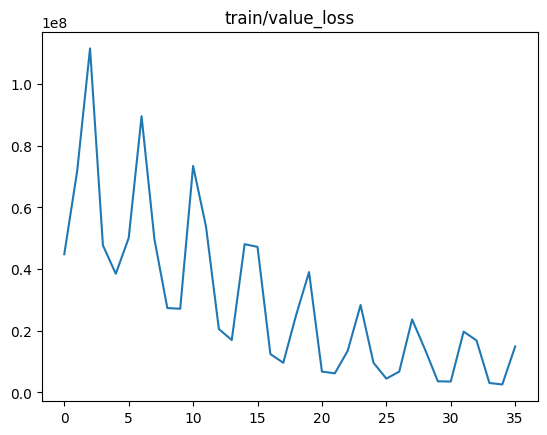

In [7]:
# Plot loss
df[df.columns[2]].plot(title=df.columns[2])
plt.show()

## Plot mean rewards

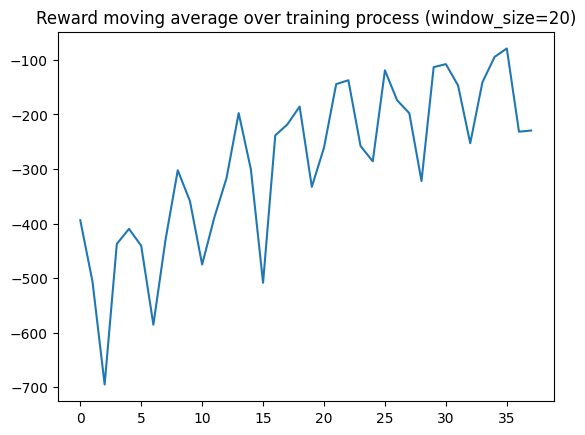

In [8]:
window_size = 20
reward_array = train_df.reward.to_numpy()

num_rows = -(-len(reward_array) // window_size)
padding_elements = num_rows * window_size - len(reward_array)
reward_array_padded = np.pad(reward_array, (0, padding_elements), mode='empty')
reward_array_aggr = reward_array_padded.reshape(-1, window_size)
reward_array_mean = np.mean(reward_array_aggr, axis=1)

plt.plot(reward_array_mean)
plt.title(f"Reward moving average over training process ({window_size=})")
plt.show()

## Evaluate the model

In [11]:
# Test the trained agent for 200h
test_episodes = 200

obs = env.reset()
step_info = []

for _ in range(test_episodes):
    action, _ = model.predict(obs)
    obs, reward, done, info = env.step(action)

    step_info.append(env.render())
    
step_df = pd.DataFrame.from_dict(step_info)

In [12]:
# Print all data for the first 4 episodes
step_df.drop(step_df.columns[10:19], axis=1).head(4)

,reward,operational_cost,purchased_energy_cost,purchased_energy_battery,purchased_energy_load,sell_back_revenue,energy_demand,energy_load,discharged,purchase_energy,solar_irradiance,wind_speed,energy_price_utility_grid
0,-47.943002,0.000000,47.943002,0.0,79.905003,0.000000,79.905003,79.905003,0,"{'load': 1, 'battery': 0}",0.1291,43.128,0.6
1,-42.278827,0.006686,42.281056,0.0,70.468426,0.008915,70.468426,70.468426,0,"{'load': 1, 'battery': 0}",0.1592,45.900,0.6
2,-202.889210,0.005153,202.888816,270.0,68.148027,0.004760,68.148027,68.148027,0,"{'load': 1, 'battery': 1}",0.0850,46.872,0.6
3,-203.301831,0.000000,203.301831,270.0,68.836385,0.000000,68.836385,68.836385,0,"{'load': 1, 'battery': 0}",0.0000,47.340,0.6


In [13]:
# Print all data about energy generation for the first 4 episodes
step_df.iloc[:,10:19].head(4)

,energy_battery_discharged,energy_generated_solar,solar,energy_generated_wind,wind,energy_generated_generator,generator,actions_adjusting_status,soc
0,0,0.000000,0,0.0,2,0,2,"{'solar': 0, 'wind': 0, 'generator': 0}",15.0
1,0,0.044576,2,0.0,0,0,0,"{'solar': 1, 'wind': 0, 'generator': 0}",15.0
2,0,0.023800,2,0.0,1,0,1,"{'solar': 1, 'wind': 0, 'generator': 0}",285.0
3,0,0.000000,0,0.0,1,0,2,"{'solar': 0, 'wind': 1, 'generator': 0}",285.0


In [14]:
# Count blackouts
print("absolute:", sum(step_df.energy_demand > step_df.energy_load))
print("relative:", sum(step_df.energy_demand > step_df.energy_load) / test_episodes)

absolute: 2
relative: 0.01


In [15]:
step_df.reward.describe()

count    200.000000
mean     -84.697083
std       53.753467
min     -382.483079
25%      -82.252041
50%      -64.840805
75%      -50.441872
max      -27.173207
Name: reward, dtype: float64

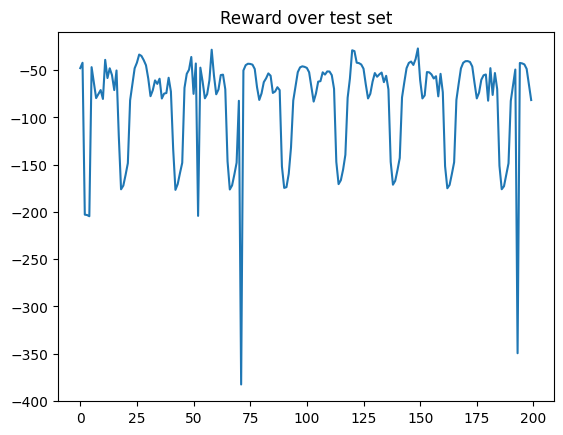

In [16]:
plt.plot(step_df["reward"])
plt.title("Reward over test set")
plt.show()

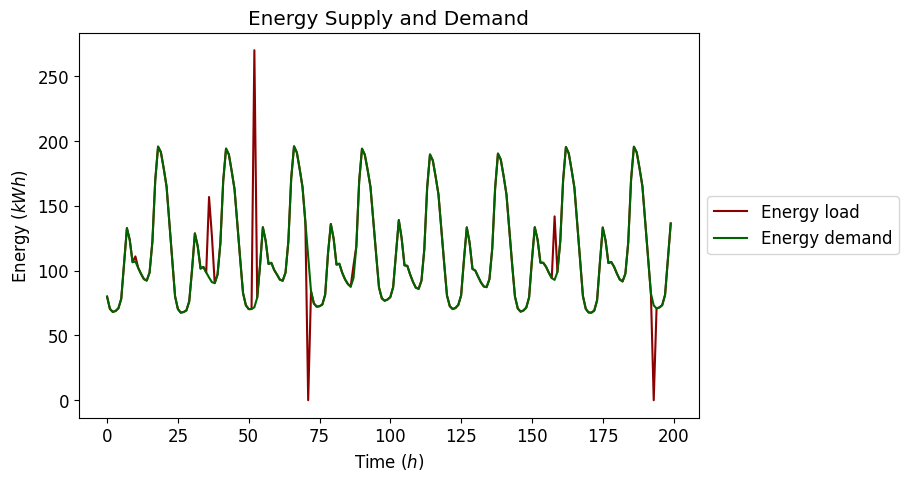

In [17]:
plot_demand_load(step_df)

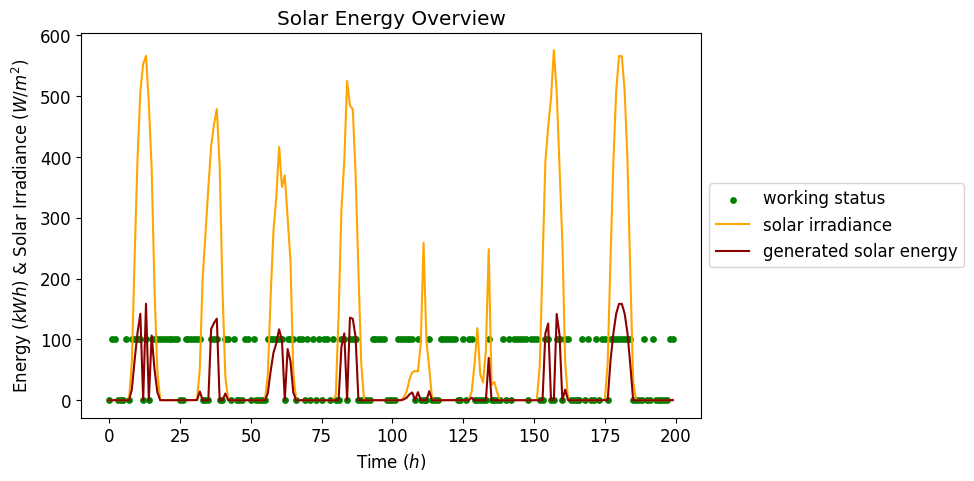

In [18]:
plot_solar_power(step_df)

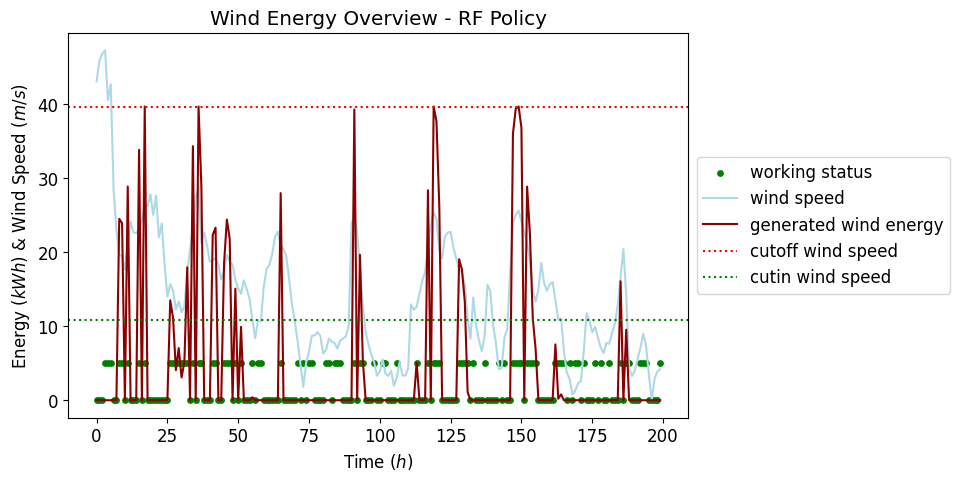

In [19]:
plot_wind_power(step_df)